In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
from fitter import Fitter
import warnings
%matplotlib inline

In this notebook, we'll examine the apparent headways and arrival patterns of travelers at subway stations.

# Initial Data Processing

We begin by loading in several days of Nanjing smartcard data. These datasets are large because they contain every entry and exit in the system for each day, so we'll make an effort to save memory and computational resources by filtering out extraneous information.

Because the smartcard data only tracks line and station entry or exit, we can't tell what direction a user is traveling without inferring that information from the user's next exit station. For this reason (as well as for efficiency), we'll restrict our analysis to each line's terminal stations only so we know for certain that all observations will be going in one direction. 

Note that `Line_Id` is not necessarily the names of the actual line, e.g.
* `Line_Id` 1: Line 1 north of Andemen (inclusive)
* `Line_Id` 3: Line 1 south of Andemen (exclusive)
* `Line_Id` 2: Line 2
* `Line_Id` 7: Line 3
* `Line_Id` 4: Line 10

In [2]:
linecode_to_line = {1:'1N', 3:'1S', 2:'2', 7:'3', 4:'10'}

terminals = {1: [16], 3: [55], 2: [17, 40], 7: [89, 113], 4: [5, 64]} # by linecode
# Line 1: maigaoqiao, cpu
# Line 2: youfangqiao, jingtianlu
# Line 3: linchang, mozhoudonglu
# Line 4: andemen, yushanlu

For each line, we'll also drop all entries and exits before the first train of the day at each station.

In [3]:
first = {16: '05:42:00', 55: '05:47:00', 17: '06:00:00', 40: '06:00:00', 89: '06:00:00', 113: '06:00:00', 5: '06:00:00', 64: '06:00:00'}

The dataframe has several columns unnecessary to this analysis, so we'll go ahead and drop those as well.

In [4]:
df = {}
# weekdays = ['20150428','20150429','20150430'] # tue, wed, thur
# weekends = ['20150425', '20150426'] # sat, sun
weekdays = ['20150429']
weekends = ['20150426']
header = pd.read_csv('../nanjing-data/header.csv')
for date in (weekdays + weekends):
    
    # attach header
    df[date] = pd.read_csv('../nanjing-data/{}.csv'.format(date), header=None)
    df[date].columns = header.columns
    
    # drop unnecessary columns
    df[date].drop(labels=['Card_Id', 'Card_Id_Long', 'Card_Type', 'Fare', 'Device_Id'], axis=1, inplace=True)
    
    # convert datetime
    df[date]['Time'] = pd.to_datetime(df[date]['Time'])
    
    # drop non-terminal stations
    for line in terminals:
        # get indices of rows with matching the line but NOT the station
        todrop = df[date].loc[(df[date]['Line_Id'] == line) & (~df[date]['StationId'].isin(terminals[line]))].index
        # drop those indices
        df[date].drop(labels=todrop, axis=0, inplace=True)
    
    # drop arrivals before first train
    for station in first:
        # construct reference time
        ref = pd.Timestamp(date + ' ' + first[station])        
        # get indices of rows which match the station but have time less than the reference time
        todrop = df[date].loc[(df[date]['StationId'] == station) & (df[date]['Time'] < ref)].index
        # drop those indices
        df[date].drop(labels=todrop, axis=0, inplace=True)
    
    df[date].sort_values(by='Time', inplace=True)
        
df[weekdays[0]].sample(10)

,Time,Entry_Or_Exit,Line_Id,StationId
1715959,2015-04-29 09:50:39,1,4,64
1305711,2015-04-29 19:37:54,2,1,16
383349,2015-04-29 07:36:55,1,1,16
561419,2015-04-29 09:49:02,1,1,16
371070,2015-04-29 18:33:58,2,2,17
1850576,2015-04-29 09:33:35,2,1,16
970949,2015-04-29 17:49:22,1,7,113
1309744,2015-04-29 08:21:28,1,2,17
1314756,2015-04-29 16:20:58,2,1,16
1882643,2015-04-29 14:34:30,2,1,16


In [5]:
def plot_day(line, Line_Id, StationId, StationName, Entry_Or_Exit=2, weekend=False):
    toplot = df[weekdays[0]]
    titleflag = ''
    fnflag = ''
    if weekend:
        toplot = df[weekends[0]]
        titleflag = 'end '
        fnflag = 'wknd_'
    eoe = 'exits'
    if Entry_Or_Exit == 1:
        eoe = 'entrances'
    plt.figure(figsize=(25,4))
    toplot.loc[(toplot['Line_Id'] == Line_Id) & (toplot['StationId'] == StationId) & (toplot['Entry_Or_Exit'] == Entry_Or_Exit)]['Time'].hist(bins=1000)
    plt.title('Station {} at {} (Line {}) over 1 week{}day'.format(eoe, StationName, line, titleflag))
    plt.ylabel(eoe)
    plt.xlabel('Datetime')
    plt.savefig('figs/{}line{}{}.png'.format(fnflag,line,eoe))
    plt.show()

# Exploratory Headway Analysis

Let's examine headways first. Fix line 10, one of its terminals, and look at entries and exits separately.

## Line 10

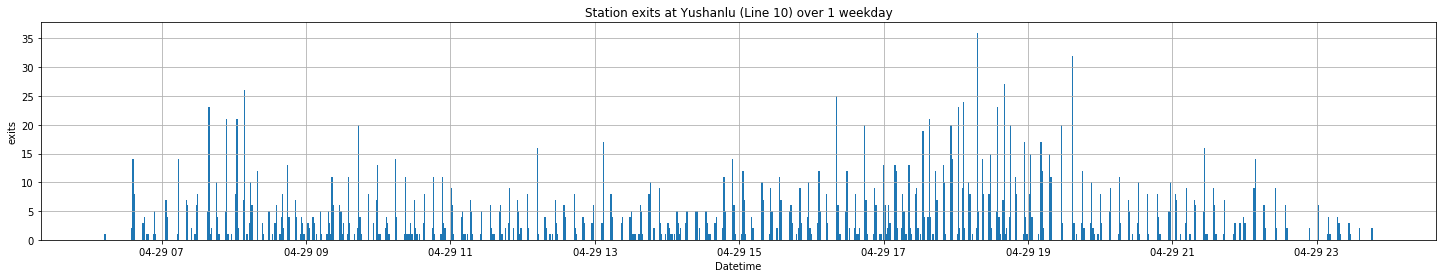

In [6]:
plot_day(10, 4, 64, 'Yushanlu')

Note the strong clustering in the data corresponding to trains arriving. There's little reason for people to loiter in station after they've gotten off at their final stop. There appears to be about a 4 minute headway corresponding peak hours between 7 and 8 in the morning and 4 to 6 in the evening (after accounting for train travel time), and an 8 minute headway during off-peak hours.

Let's examine the weekend as well.

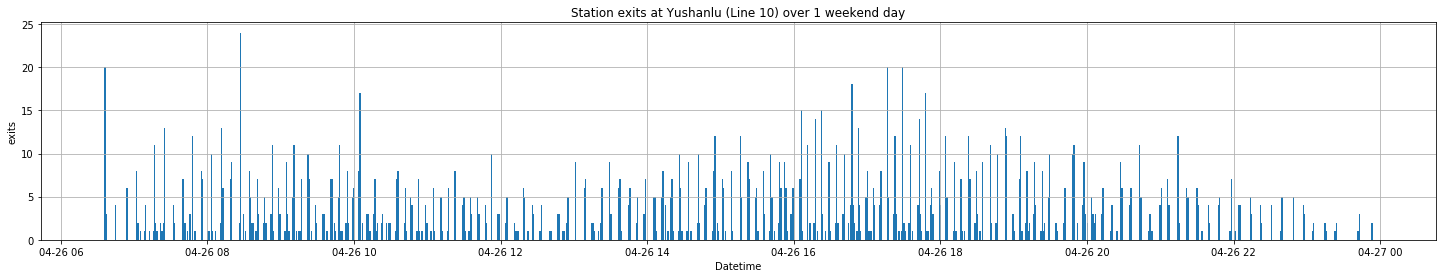

In [7]:
plot_day(10, 4, 64, 'Yushanlu', weekend=True)

And take a look at entrances for comparison.

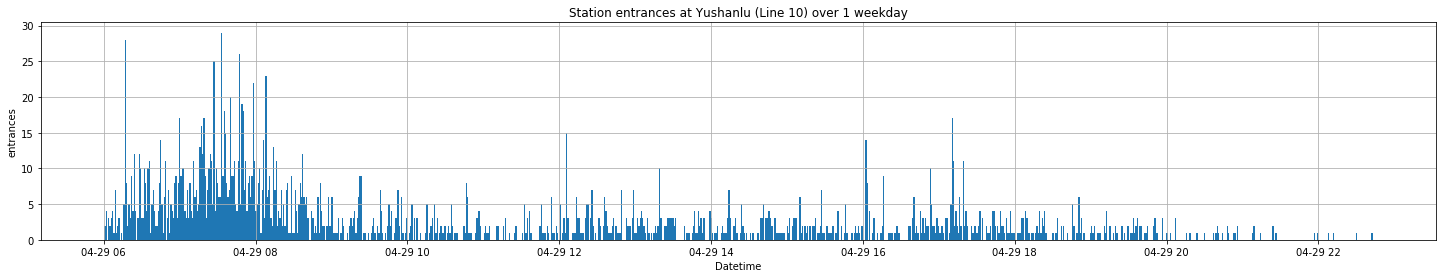

In [8]:
plot_day(10, 4, 64, 'Yushanlu', Entry_Or_Exit=1)

We see that the periodicity for station entrances, while still somewhat visible, is much less clear than station exits. Let's take a quick look at the headways of other lines based on their exit patterns before moving on.

## Line 1

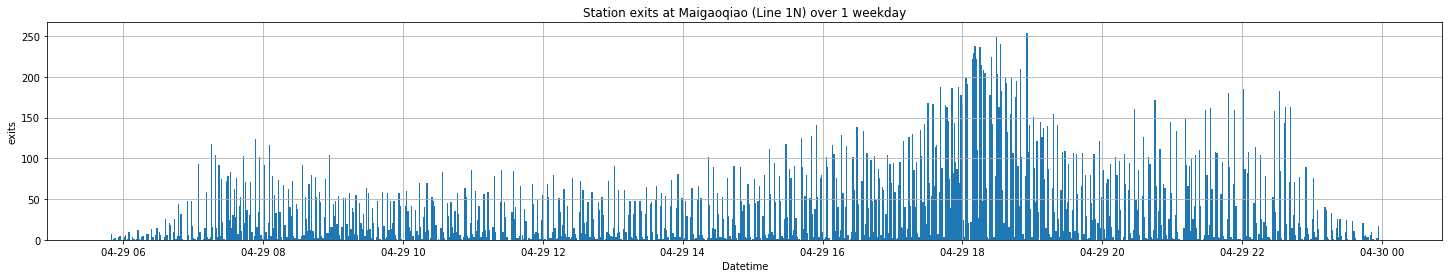

In [9]:
plot_day('1N', 1, 16, 'Maigaoqiao')

The headway on the northern portion of Line 1 is very short, 3 minutes, which this plot of weekday exits corroborates well.

The weekend is less clear, while there isn't much to glean from station entrances.

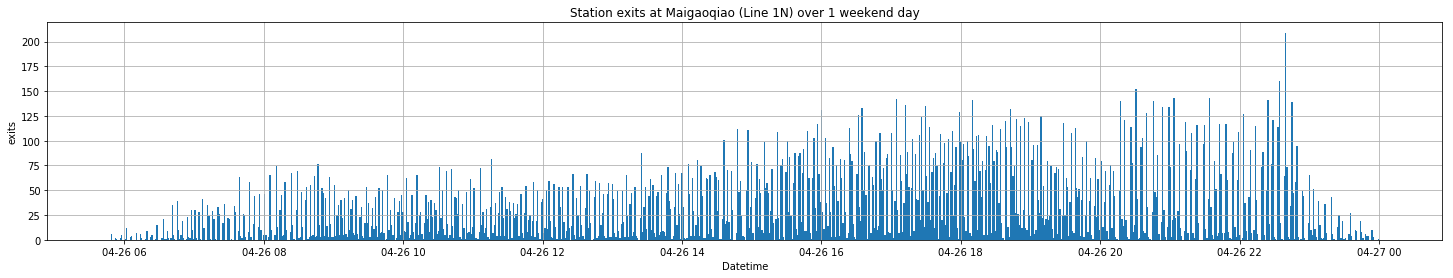

In [10]:
plot_day('1N', 1, 16, 'Maigaoqiao', weekend=True)

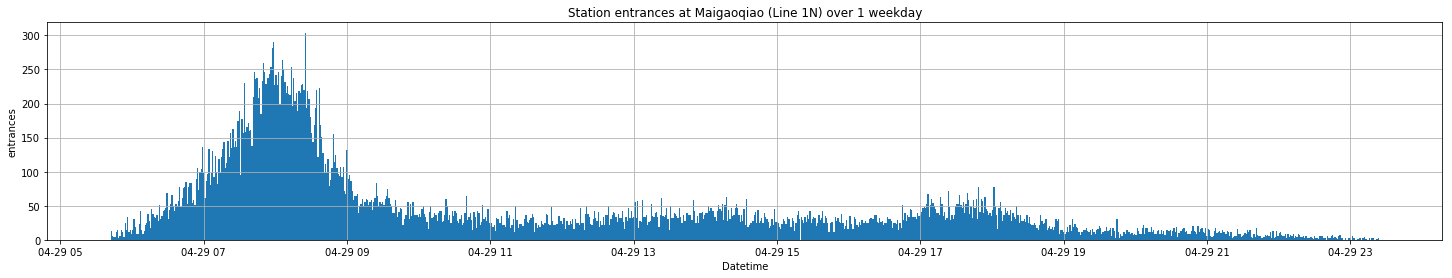

In [11]:
plot_day('1N', 1, 16, 'Maigaoqiao', Entry_Or_Exit=1)

And on the south end with a different headway?

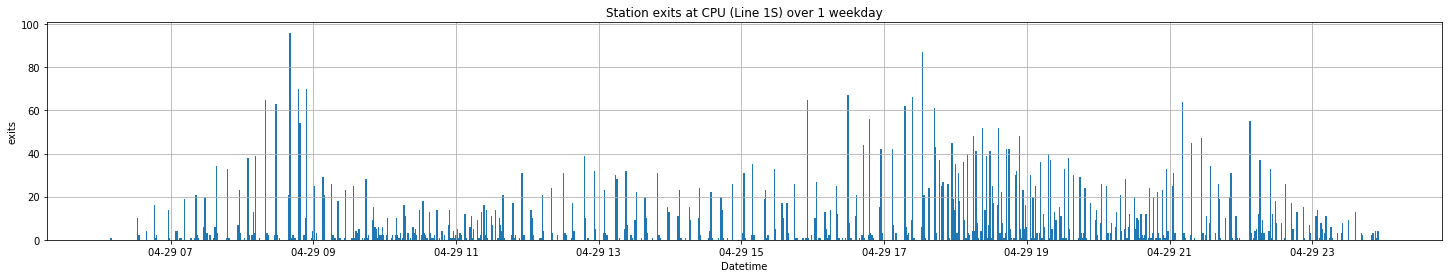

In [12]:
plot_day('1S', 3, 55, 'CPU')

Over on the southern portion of Line 1, headway appears to be about 4 minutes during peak hours in the morning and evening and 8 minutes otherwise.

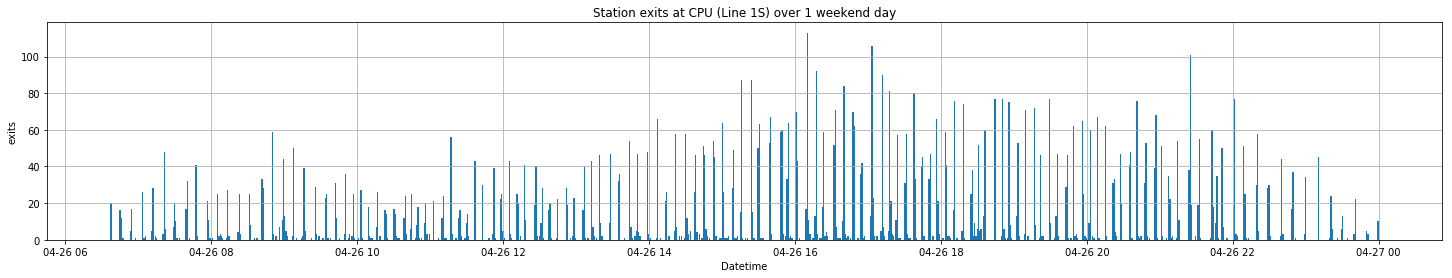

In [13]:
plot_day('1S', 3, 55, 'CPU', weekend=True)

## Line 2

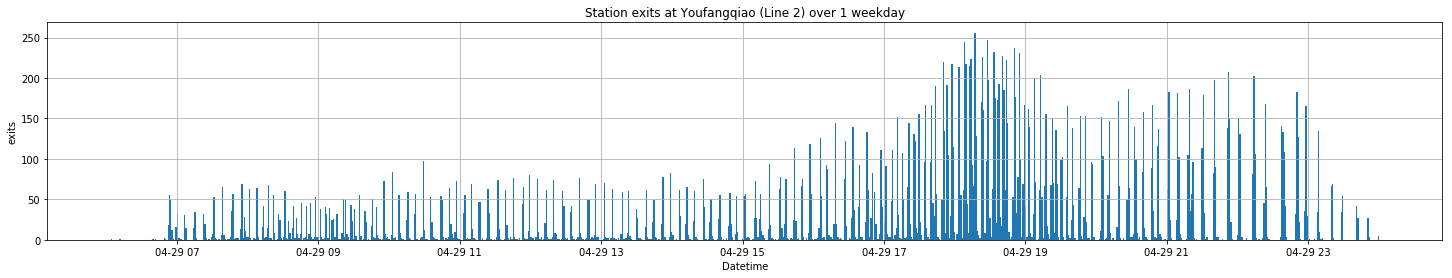

In [14]:
plot_day(2, 2, 17, 'Youfangqiao')

Line 2 likewise seems to have peak and non-peak hours with 5 and 7 minute headways respectively. 

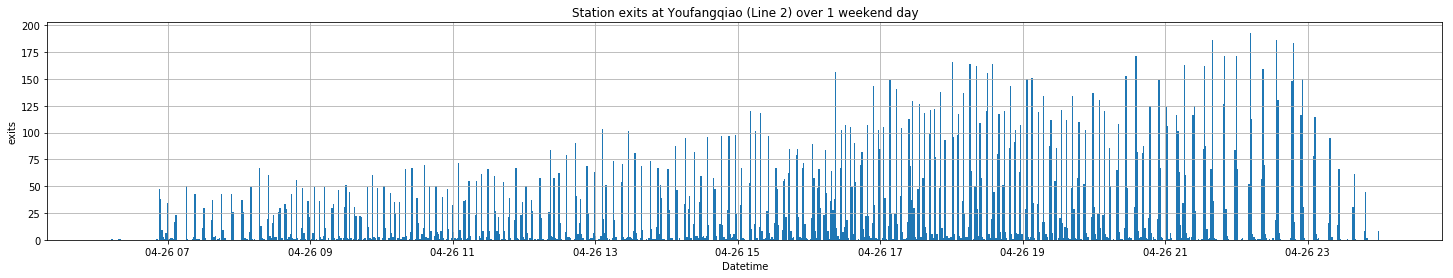

In [15]:
plot_day(2, 2, 17, 'Youfangqiao', weekend=True)

## Line 3

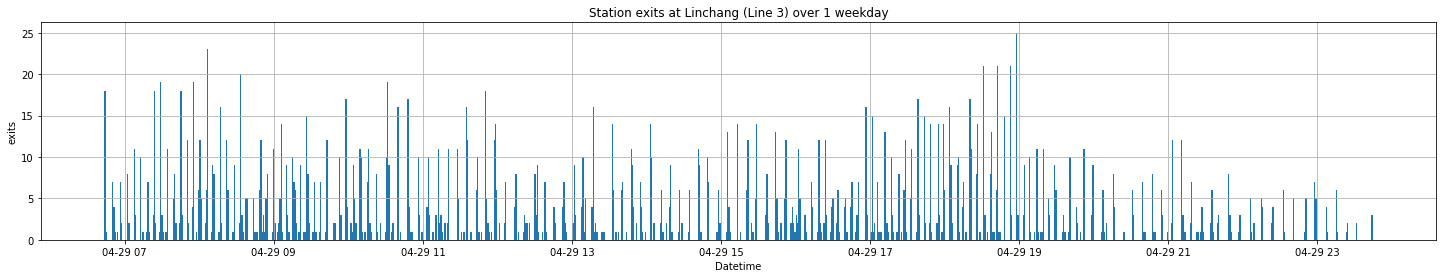

In [16]:
plot_day(3, 7, 89, 'Linchang')

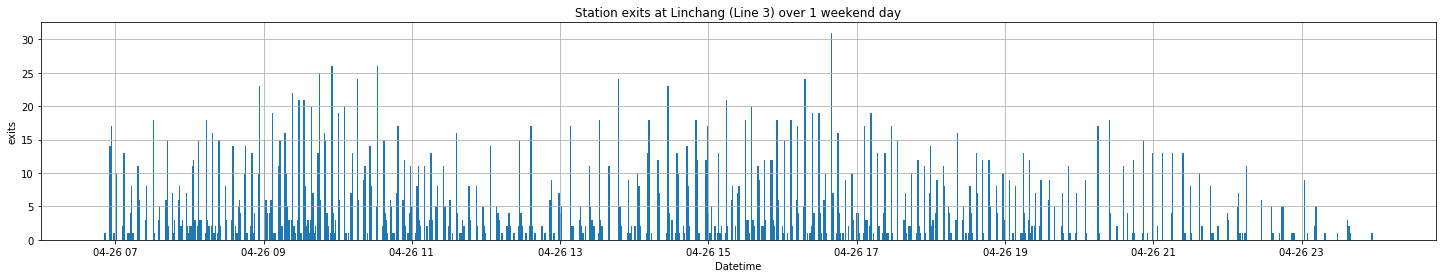

In [17]:
plot_day(3, 7, 89, 'Linchang', weekend=True)

Even when cross-referencing various online sources and these empirical distributions, it's hard to tell when peak hours are or the actual train headway. Surprisingly, there doesn't seem to be a significant difference between weekday and weekend headways.

# Simple Arrival Distribution Analysis

On weekdays, the north portion of Line 1 has a fixed headway of 3 minutes (that is to say, at each station every 3 minutes another train arrives). Line 1 has a fixed, predictable headway of 3 minutes all day on weekdays, so the question we want to consider is if travelers adjust their arrival times are the station to account for these departures.

We'll begin with the following processing steps:
1. Pull out just the `Timestamp`s of entries at the Line 1 north terminus
2. Convert raw `Timestamp` to `Timedelta` hours after midnight on the day the data is from
3. Adjust `Timedelta` to time elapsed since the first train of the day
4. Convert `Timedelta` to seconds for easier calculations.
5. Use the module operator to bring all time

In [18]:
hw1 = 3*60 # seconds

df1 = {}

for date in weekdays:
    df1[date] = df[date].loc[(df[date]['Line_Id'] == 1) & (df[date]['Entry_Or_Exit'] == 1)]
    df1[date] = df1[date].loc[df1[date]['Entry_Or_Exit'] == 1]
    df1[date] = df1[date].loc[:,['Time']]
    
    # timestamp - midnight of day - time of first train of day
    df1[date]['Time'] = (df1[date]['Time'] - pd.Timestamp(date) - pd.Timedelta(first[terminals[1][0]])).dt.seconds
    
    # account for periodicity
    df1[date]['adj_time'] = df1[date]['Time'] % hw1
    df1[date]['arr_period'] = df1[date]['Time'] // hw1    
    
df1[weekdays[0]].head()

,Time,adj_time,arr_period
113726,4,4,0
780703,5,5,0
1602094,11,11,0
113727,12,12,0
1602095,14,14,0


We'll approach this analysis on two fronts: trying the distribution without normalizing per 3-minute interval, and then doing so and comparing the differences.

## Distribution fitting without normalization

This method should be more accurate to the way we observe passengers arriving, but rush hour passengers may drown out passengers arriving during off-peak times.

We take all the arrival times since the first train and use the modulo operator to bring everything into a repeating 3-minute period

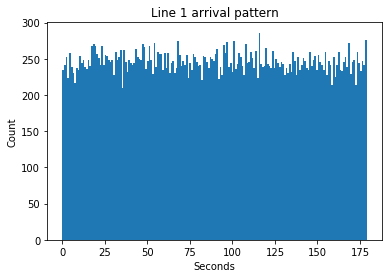

In [19]:
ap1 = np.array([])
for date in weekdays:
    ap1 = np.append(ap1, df1[date]['adj_time'].values)

plt.hist(ap1,bins=hw1)
plt.xlabel('Seconds')
plt.ylabel('Count')
plt.title('Line 1 arrival pattern')
plt.savefig('figs/l1arrivalpattern.png')
plt.show()

Looks uniform, but let's see what distribution fits this best.

/home/carlin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/carlin/anaconda3/lib/python3.6/site-packages/fitter/fitter.py:305: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  return self.df_errors.ix[names]


,sumsquare_error
uniform,0.000016
gennorm,0.000016
kappa4,0.000016
powerlaw,0.000027
gausshyper,0.000038


/home/carlin/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1615: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


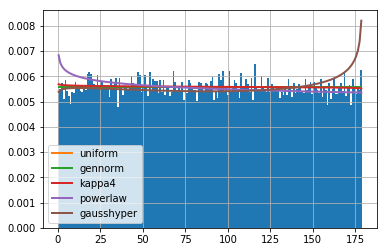

In [20]:
f1 = Fitter(ap1,bins=hw1,verbose=False)
warnings.simplefilter('ignore')
f1.fit()
warnings.simplefilter('default')
f1.summary()

Yep, it's uniform.

## Distribution fitting by period with normalization

Now instead of fitting a distribution by each arrival, we'll normalize 

1. group arrivals by period
2. loop through periods, skipping periods with too few arrivals
    a. bin arrivals during the period into intervals of 1 second (the resolution of our dataset)
    b. divide the resulting counts by the total number of arrivals in the period
    c. fold the resulting distribution into into a running dataset 
3. fit on the resulting array

/home/carlin/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1615: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


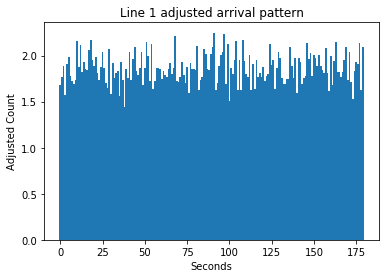

In [21]:
ad1 = np.zeros(hw1)
for date in weekdays:
    for name, group in df1[date].groupby('arr_period'):
        if group.shape[0] > 10:
            holder = np.zeros(hw1)
            for minute in group['adj_time']:
                holder[minute] += 1
            holder = holder/np.sum(holder)
            ad1 = ad1 + holder

plt.bar(np.arange(hw1),ad1,width=1)
plt.xlabel('Seconds')
plt.ylabel('Adjusted Count')
plt.title('Line 1 adjusted arrival pattern')
plt.savefig('figs/l1adjarrivalpattern.png')
plt.show()

/home/carlin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/carlin/anaconda3/lib/python3.6/site-packages/fitter/fitter.py:305: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  return self.df_errors.ix[names]


,sumsquare_error
uniform,0.000042
gennorm,0.000042
vonmises_line,0.000042
kappa4,0.000042
powerlaw,0.000042


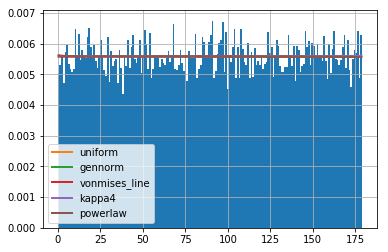

In [22]:
ad1 = np.repeat(np.arange(hw1),(np.rint(ad1*100)).astype(int))
f2 = Fitter(ad1,bins=hw1,verbose=False)
warnings.simplefilter('ignore')
f2.fit()
warnings.simplefilter('default')
f2.summary()

So we see that, at least for a fixed headway of three minutes, the distribution of travelers entering the station for the next train can be approximated as uniform. This is likely because a 3-minute headway is short enough for it not to matter much to each traveler when they get to a station, since even in the worst case scenario they only need to wait 3 minutes or less.

# Fitting Time Deltas Between Entrances

As suggested by the exploratory analysis, we'll proceed by caculating the time deltas between traveler station entrances. Assuming that travelers' entrance times are not related to when the next train arrives, an exponential distribution should represent it accurately.

## Data processing

We'll start by converting arrivals at each line's terminal station into differences between each traveler's station entrance.

In [23]:
def extract_line_deltas(df_day, linecode, station):
    df = df_day.loc[(df_day['Entry_Or_Exit'] == 2) & (df_day['Line_Id'] == linecode) & (df_day['StationId'] == station),:].copy()
    df.sort_values('Time', inplace=True)
    df['deltas'] = df['Time'].diff().dt.seconds
    df.drop(['Entry_Or_Exit', 'Line_Id', 'StationId'], axis=1, inplace=True)
    return df#.reset_index(drop=True)

def estimate_headway(df_day, linecode, station, quantile=.98): # benchmarked to line 1's known headway of 180s
    # given a day of entrances and exits for all stations and all lines,
    # use gaps between exits to infer an average headway (ignoring rush hour vs. non-rush)
    # benchmarked according to line 1's known headway of 180s and known approximate headways of 6-8 min for other lines
    
    times = df_day.loc[(df_day['Entry_Or_Exit'] == 2) & (df_day['Line_Id'] == linecode) & (df_day['StationId'] == station),:]['Time'].sort_values()
    diff = times.diff().dt.seconds
    diff = times[(diff > 5)].diff().dt.seconds
    return diff[(diff < 11*60)].quantile(q=quantile)

In [24]:
dft = {} # weekdays
dfe = {} # weekends
headways = pd.Series(name='est_headway')
for line in terminals:
    # create series indexed by line to reference for estimated headways to compare fit
    headways.loc[line] = estimate_headway(df[weekdays[0]], line, terminals[line][0])
    dft[line] = extract_line_deltas(df[weekdays[0]], line, terminals[line][0])
    dfe[line] = extract_line_deltas(df[weekends[0]], line, terminals[line][0])
headways

1    187.00
3    402.00
2    236.22
7    407.24
4    422.50
Name: est_headway, dtype: float64

In [25]:
dft[1].head()

,Time,deltas
1320624,2015-04-29 05:49:03,NaN
1601815,2015-04-29 05:49:06,3.0
1062061,2015-04-29 05:49:11,5.0
1601816,2015-04-29 05:49:13,2.0
1852791,2015-04-29 05:49:18,5.0


## Fitting exponential distributions

For each line, we'll attempt to fit an exponential distribution to each line's time deltas. Or, more accurately, we'll attempt to fit two separate distributions, with one parameter during rush hour (when we expect more people to be using the subway and thus for deltas to be shorter), and another for other times. 

As a proof of concept, let's fit an naive exponential distribution to one of the lines without accounting for variations in traveler density over a given day.

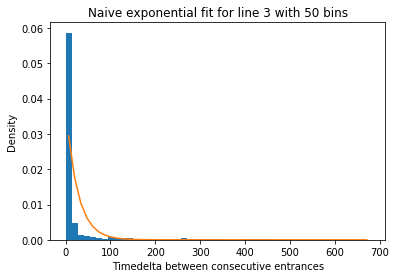

0.0047769827379001029

In [26]:
loc, scale = st.expon.fit(dft[7]['deltas'][1:])
y, x = np.histogram(dft[7]['deltas'][1:], bins=50, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0 # move xs from edge of bins to middle
pdf = st.expon.pdf(x,loc,scale)
plt.hist(dft[7]['deltas'][1:], density=1, bins=50)
plt.plot(x,pdf)
plt.title('Naive exponential fit for line 3 with 50 bins')
plt.xlabel('Timedelta between consecutive entrances')
plt.ylabel('Density')
plt.savefig('figs/naivefit.png',dpi=600)
plt.show()
rmse = np.sqrt(np.sum(np.power(y-pdf,2))/pdf.shape[0])
rmse

The fit is not unreasonable, but what about peak hours when both trains and people are running more frequently?

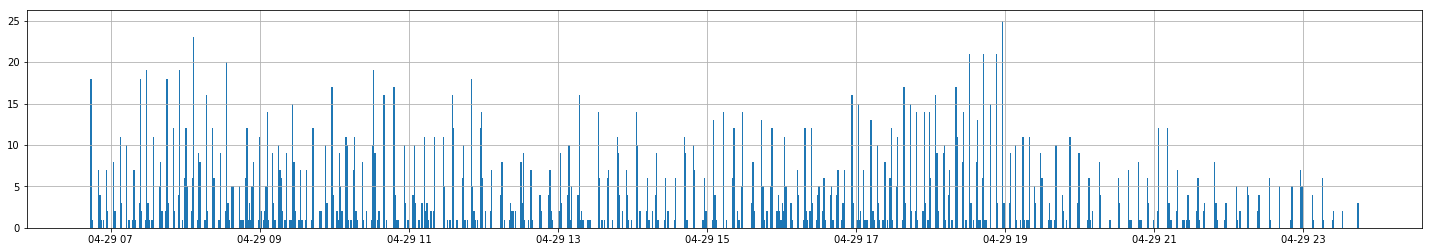

In [27]:
plt.figure(figsize=(25,4))
dft[7]['Time'].hist(bins=1000)

Visually we'll judge rush hour to run from opening around 6 am to 10 am and from 4 pm to 8 pm and fit different exponentials to both. Doing so for all lines,

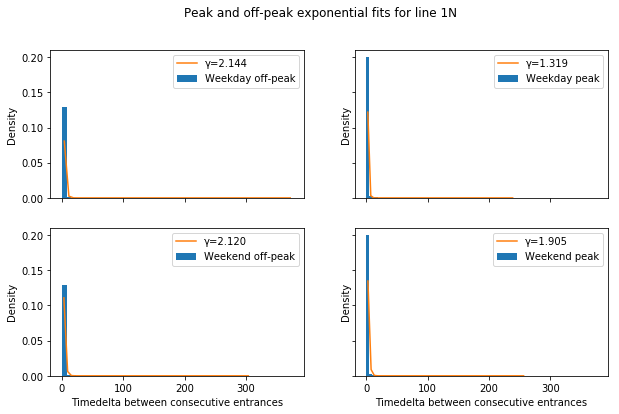

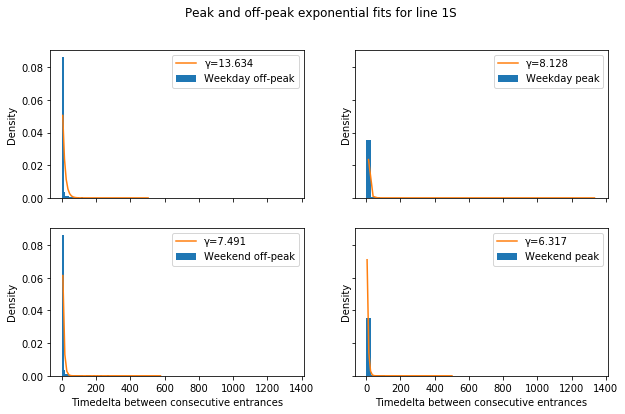

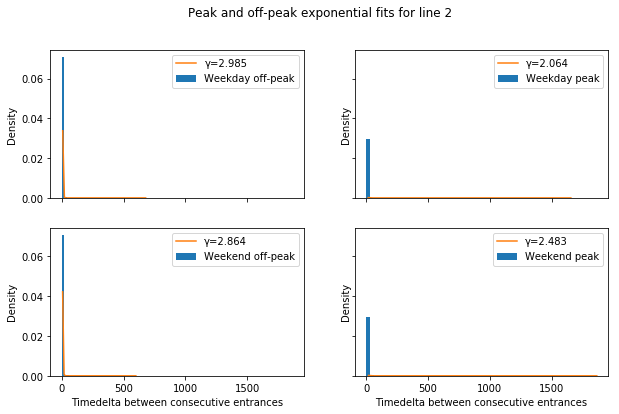

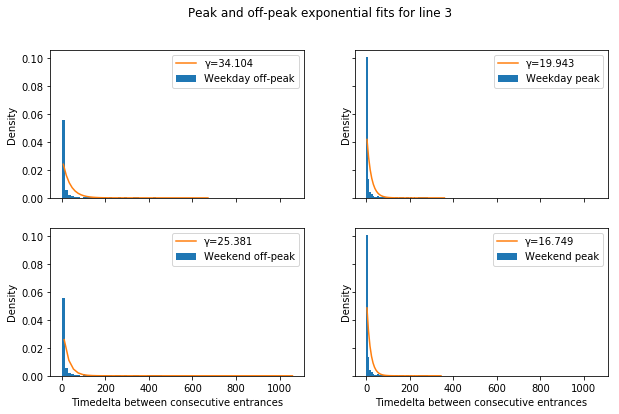

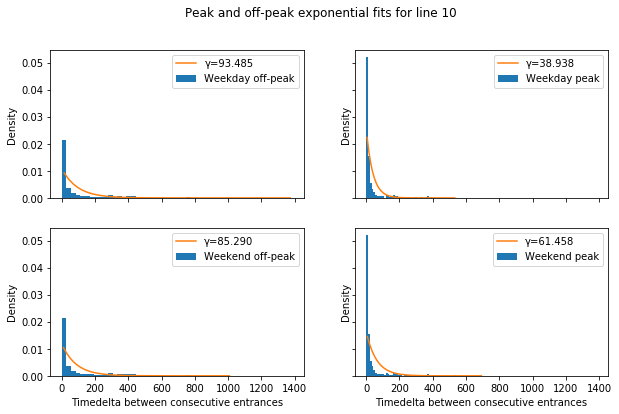

,offp_loc,offp_scale,peak_loc,peak_scale,rmse,e_offp_loc,e_offp_scale,e_peak_loc,e_peak_scale,e_rmse,est_headways
1,-4.67561e-12,2.14377,-2.37127e-10,1.31899,0.00922333,-1.45729e-09,2.12037,-2.67154e-08,1.90523,0.00674657,187.00
3,-1.55316e-08,13.6336,-1.2235e-09,8.12826,0.00445547,-1.65289e-10,7.49126,-2.03506e-10,6.31664,0.0035496,402.00
2,-4.70104e-10,2.98476,-1.71117e-10,2.06439,0.00474562,-8.18374e-11,2.86369,-3.75882e-09,2.48262,0.00460228,236.22
7,-1.24667e-08,34.1042,-7.28932e-09,19.9432,0.00743172,-7.19484e-11,25.3814,-1.65811e-10,16.7494,0.00650531,407.24
4,-5.5383e-08,93.4848,-1.66244e-11,38.9384,0.00353546,-5.63659e-11,85.2896,-6.83978e-11,61.4578,0.0033582,422.50


In [28]:
fitres = pd.DataFrame(columns=['offp_loc', 'offp_scale', 'peak_loc', 'peak_scale', 'rmse', 'e_offp_loc', 'e_offp_scale', 'e_peak_loc', 'e_peak_scale', 'e_rmse'])
for line in terminals:
    # create table of fit params
    
    # drop first delta due to NaN
    d = dft[line].iloc[1:,:]
    de = dfe[line].iloc[1:,:]
    
    # batch peak and regular deltas
    peakers = (
        ((d['Time'] < pd.Timestamp(weekdays[0] + ' 10:00:00'))) # morning rush
        | ((pd.Timestamp(weekdays[0] + ' 16:00:00') < d['Time']) & (d['Time'] < pd.Timestamp(weekdays[0] + ' 20:00:00'))) # evening rush
    )
    dpeak = d.loc[peakers, 'deltas']
    doffp = d.loc[~peakers, 'deltas']
    # weekend
    peakerse = (
        ((de['Time'] < pd.Timestamp(weekends[0] + ' 10:00:00'))) # morning rush
        | ((pd.Timestamp(weekends[0] + ' 16:00:00') < de['Time']) & (de['Time'] < pd.Timestamp(weekends[0] + ' 20:00:00'))) # evening rush
    )
    dpeake = de.loc[peakerse, 'deltas']
    doffpe = de.loc[~peakerse, 'deltas']
    
    
    # fit peak deltas
    ploc, pscale = st.expon.fit(dpeak)
    ploce, pscalee = st.expon.fit(dpeake)
    
    # fit off-peak deltas
    oloc, oscale = st.expon.fit(doffp)
    oloce, oscalee = st.expon.fit(doffpe)
    
    # calculate RMSE for 50 bins    
    # peak
    yp, xp = np.histogram(dpeak, bins=50, density=True)
    xp = (xp + np.roll(xp, -1))[:-1] / 2.0 # move xs from edge of bins to middle
    pdfp = st.expon.pdf(xp,ploc,pscale)    
    # off-peak
    yo, xo = np.histogram(doffp, bins=50, density=True)
    xo = (xo + np.roll(xo, -1))[:-1] / 2.0 # move xs from edge of bins to middle
    pdfo = st.expon.pdf(xo,oloc,oscale)    
    # rmse
    rmse = np.sqrt((np.sum(np.power(yp-pdfp,2)) + np.sum(np.power(yo-pdfo,2)))/(pdfp.shape[0]+pdfo.shape[0]))
    # weekend
    # peak
    ype, xpe = np.histogram(dpeake, bins=50, density=True)
    xpe = (xpe + np.roll(xpe, -1))[:-1] / 2.0 # move xs from edge of bins to middle
    pdfpe = st.expon.pdf(xpe,ploce,pscalee)    
    # off-peak
    yoe, xoe = np.histogram(doffpe, bins=50, density=True)
    xoe = (xoe + np.roll(xoe, -1))[:-1] / 2.0 # move xs from edge of bins to middle
    pdfoe = st.expon.pdf(xoe,oloce,oscalee)    
    # rmse
    rmsee = np.sqrt((np.sum(np.power(ype-pdfpe,2)) + np.sum(np.power(yoe-pdfoe,2)))/(pdfp.shape[0]+pdfo.shape[0]))
    
        
    # plot peak and off-peak deltas side-by-side
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 6))
    fig.suptitle('Peak and off-peak exponential fits for line {}'.format(linecode_to_line[line]))
    # off-peak
    plt.sca(ax[0,0])
    plt.hist(doffp, density=1, bins=50, label='Weekday off-peak')
    plt.plot(xo,pdfo, label='γ={0:.3f}'.format(oscale))
#     plt.xlabel('Timedelta between consecutive entrances')
    plt.ylabel('Density')
    plt.legend()
    # peak
    plt.sca(ax[0,1])
    plt.hist(dpeak, density=1, bins=50, label='Weekday peak')
    plt.plot(xp,pdfp, label='γ={0:.3f}'.format(pscale))
#     plt.xlabel('Timedelta between consecutive entrances')
    plt.ylabel('Density')
    plt.legend()    
    # weekend
    # off-peak
    plt.sca(ax[1,0])
    plt.hist(doffp, density=1, bins=50, label='Weekend off-peak')
    plt.plot(xoe,pdfoe, label='γ={0:.3f}'.format(oscalee))
    plt.xlabel('Timedelta between consecutive entrances')
    plt.ylabel('Density')
    plt.legend()
    # peak
    plt.sca(ax[1,1])
    plt.hist(dpeak, density=1, bins=50, label='Weekend peak')
    plt.plot(xpe,pdfpe, label='γ={0:.3f}'.format(pscalee))
    plt.xlabel('Timedelta between consecutive entrances')
    plt.ylabel('Density')
    plt.legend()    
    plt.savefig('figs/fit-line{}.png'.format(linecode_to_line[line]),dpi=600)
    plt.show()
    
    # add results to df
    fitres.loc[line,:] = [oloc, oscale, ploc, pscale, rmse, oloce, oscalee, ploce, pscalee, rmsee]
fitres['est_headways'] = headways
fitres

Our hypothesis, that as headways increase people would adjust their arrival times, would require that headways of longer length cause exponential fits to be less accurate. Comparing our RMSE to our estimated headways, we see that the relationship between the two seems to exist but may be weak. Across weekday and weekend, error does seem to increase as headway increases; however, of the five lines, line 1 south exhibits both higher headway and lower error, which may be reflective of its explicit connection with the low-headway line 1 north.

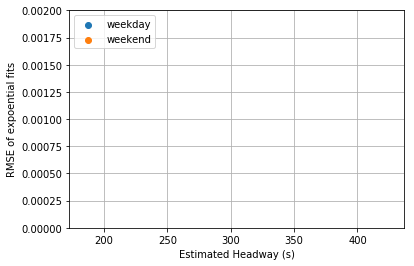

In [29]:
plt.scatter(fitres['est_headways'],fitres['rmse'], label='weekday')
plt.scatter(fitres['est_headways'],fitres['e_rmse'], label='weekend')
plt.xlabel('Estimated Headway (s)')
plt.ylabel('RMSE of expoential fits')
plt.ylim([0, 0.002])
plt.grid()
plt.legend(loc='upper left')
plt.savefig('figs/fitperf.png', dpi=600)
plt.show()

# Tuning the fit

As a baseline, we see that the RMSE for Line 3 with rush hour and regular hours split is somewhat improved from the naive fit ($3.54 \times 10^{-3}$ compared to $4.777 \times 10^{-3}$). This seems like it was the correct choice, but let's empirically determine if including this additional degree of freedom was worth the marginal gain in accuracy, and if other splitting methods would achieve even better results. I'll be demonstrating this technique on Line 3 on a weekday only as a proof of concept, but this process can be extended to the other lines on other days as well.

First, let's examine the Line 3 timedeltas dataset and decide what methods we'll use to chunk this dataset for fitting.

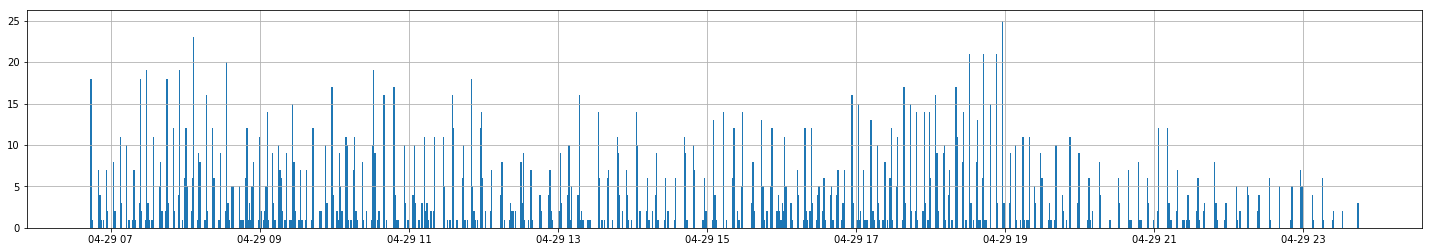

In [30]:
plt.figure(figsize=(25,4))
dft[7]['Time'].hist(bins=1000)

Morning and evening rush hour periods seem to be the primary difference-makers, so we'll divide the day according to those timeframes, specifically the morning rush hour period from 6-10am, the midday off-peak period from 10am-4pm, the evening rush hour period from 4pm-8pm, and the night off-peak hours from 8pm-12am. Looking back to our rush hour/non-rush hour fit results, we notice that the loc of every one of our models, peak or off-peak, are very close to zero, so for our purposes we'll be fixing the loc for each fit to 0 so the only change we make is for how many exponentials we fit to the dataset.

With this in mind, we'll split the dataset in the following ways for comparison:
1. No splitting $(k=1)$
2. Batch both rush hours, batch both non-rush periods $(k=2)$
3. Fit rush hour periods separately, batch both non-rush periods $(k=3)$
4. Batch both rush hours, fit non-rush periods separately $(k=3)$
5. Fit both rush hour and both non-rush periods separately $(k=4)$.

The process to evaluate each split will be:
1. Use `scipy.stats.expon.fit` to find us the MLE $\gamma$ values for however many exponentials the split dictates
2. Calculate the maximum log-likelihood $\ln(\hat{L}) = \sum_{i=1}^k \left( n_i \ln{\gamma_i} - \gamma_i \sum_{j=1}^{n_i} x_j \right)$
3. Calculate the Akaike Information Criterion (AIC) using $AIC = 2k - 2\ln(\hat{L})$
4. Calculate the Bayesian Information Criterion (BIC) using $BIC = \ln{n}k - 2\ln(\hat{L})$

Using the AIC and BIC values, we'll compare results and identify the best split.

In [31]:
def find_best_split(df_day_line, day_text, split_any=False, split_rush=False, split_off=False):
    # find param a certain split
    # df_day: 1 day of timedeltas for a specific line
    # day_text: corresponding day in text form for parsing
    # split_any: determines if rush hours are split apart from regular hours. if false, overrides split_rush and split_off
    # split_rush: determines if morning and evening rush hour periods are split apart
    # split_off: determined if midday and night off-peak periods are split apart
    
    dfl = df_day_line[1:] # drop first NaN term    
    
    dfs = []
    if split_any:
        
        r1 = dfl.loc[(dfl['Time'] < pd.Timestamp(day_text + ' 10:00:00')), 'deltas']
        r2 = dfl.loc[(pd.Timestamp(day_text + ' 16:00:00') < dfl['Time']) & (dfl['Time'] < pd.Timestamp(day_text + ' 20:00:00')), 'deltas']
        if split_rush:
            dfs.append(r1) # morning rush
            dfs.append(r2) # evening rush
        else:
            dfs.append(r1.append(r2)) # rush in general
        
        o1 = dfl.loc[(pd.Timestamp(day_text + ' 10:00:00') < dfl['Time']) & (dfl['Time'] < pd.Timestamp(day_text + ' 16:00:00')), 'deltas']
        o2 = dfl.loc[pd.Timestamp(day_text + ' 20:00:00') < dfl['Time'], 'deltas']
        if split_off:
            dfs.append(o1) # midday off-peak
            dfs.append(o2) # night off-peak
        else:
            dfs.append(o1.append(o2))  
        
    else: 
        dfs.append(dfl['deltas'])
    
    # setup gamma, aic, bic formulas
    k = len(dfs)
    n = dfl.shape[0]
    best_gammas = []
    aic = 2*k
    bic = np.log(n)*k
    
    for df in dfs:
        loc, gamma = st.expon.fit(df, floc=0.0)
        best_gammas.append(gamma)
        
        ni = df.shape[0]
        lml = ni * np.log(gamma) - gamma*df.sum()
        
        aic -= 2*lml
        bic -= 2*lml
        
    # best gammas is [(overall gamma if requested), (rush hour gamma(s) if requested), (off peak gamma(s) if requested)]
    return best_gammas, aic, bic

In [32]:
def tuner(df_day_line, day_text):
    # find params for best split
    # df_day: 1 day of timedeltas for a specific line
    # day_text: corresponding day in text form for parsing
    tuneres = pd.DataFrame(columns=['gammas', 'aic', 'bic'])

    # index on tuning results dataframe with id corresponding to splitting as described in cell above
    gammas, aic, bic = find_best_split(df_day_line, day_text)
    tuneres.loc[1] = [gammas, aic, bic]
    gammas, aic, bic = find_best_split(df_day_line, day_text, split_any=True)
    tuneres.loc[2] = [gammas, aic, bic]
    gammas, aic, bic = find_best_split(df_day_line, day_text, split_any=True, split_rush=True)
    tuneres.loc[3] = [gammas, aic, bic]
    gammas, aic, bic = find_best_split(df_day_line, day_text, split_any=True, split_off=True)
    tuneres.loc[4] = [gammas, aic, bic]
    gammas, aic, bic = find_best_split(df_day_line, day_text, split_any=True, split_rush=True, split_off=True)
    tuneres.loc[5] = [gammas, aic, bic]
    
    aic_choice = tuneres['aic'].idxmin()
    bic_choice = tuneres['bic'].idxmin()
    
    return tuneres, aic_choice, bic_choice

tuneres, aic_choice, bic_choice = tuner(dft[7], weekdays[0])
tuneres

,gammas,aic,bic
1,[26.1172632216],3.183804e+06,3.183810e+06
2,"[19.9056026604, 34.0339767328]",3.414609e+06,3.414620e+06
3,"[19.5541000433, 20.2019530845, 34.0339767328]",3.414886e+06,3.414904e+06
4,"[19.9056026604, 26.4009547101, 63.3474085091]",3.876128e+06,3.876145e+06
5,"[19.5541000433, 20.2019530845, 26.4009547101, ...",3.876406e+06,3.876429e+06


In [33]:
print('Split schema with minimum AIC: ', aic_choice)
print('Split schema with minimum BIC: ', bic_choice)

Split schema with minimum AIC:  1
Split schema with minimum BIC:  1


We see that both AIC and BIC agree on not splitting by rush hour at all to be the ideal method to approaching this dataset.

How does this generalize to other lines? And for the weekend?

Weekday split schema for Line 1N with minimum AIC:  1
Weekday split schema for Line 1N with minimum BIC:  1

Weekend split schema for Line 1N with minimum AIC:  1
Weekend split schema for Line 1N with minimum BIC:  1

Weekday split schema for Line 1S with minimum AIC:  1
Weekday split schema for Line 1S with minimum BIC:  1

Weekend split schema for Line 1S with minimum AIC:  1
Weekend split schema for Line 1S with minimum BIC:  1

Weekday split schema for Line 2 with minimum AIC:  1
Weekday split schema for Line 2 with minimum BIC:  1

Weekend split schema for Line 2 with minimum AIC:  1
Weekend split schema for Line 2 with minimum BIC:  1

Weekday split schema for Line 3 with minimum AIC:  1
Weekday split schema for Line 3 with minimum BIC:  1

Weekend split schema for Line 3 with minimum AIC:  1
Weekend split schema for Line 3 with minimum BIC:  1

Weekday split schema for Line 10 with minimum AIC:  1
Weekday split schema for Line 10 with minimum BIC:  1

Weekend split schema for Li

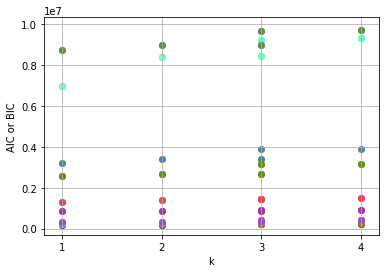

In [34]:
ks = [1, 2, 3, 3, 4]
for line in dft:
    tuneres, aic_choice, bic_choice = tuner(dft[line], weekdays[0])
    print('Weekday split schema for Line {} with minimum AIC: '.format(linecode_to_line[line]), aic_choice)
    print('Weekday split schema for Line {} with minimum BIC: '.format(linecode_to_line[line]), bic_choice)
    plt.scatter(ks, tuneres['aic'], c=np.random.rand(3,))
    plt.scatter(ks, tuneres['bic'], c=np.random.rand(3,))
    print()
    tuneres, aic_choice, bic_choice = tuner(dfe[line], weekends[0])
    print('Weekend split schema for Line {} with minimum AIC: '.format(linecode_to_line[line]), aic_choice)
    print('Weekend split schema for Line {} with minimum BIC: '.format(linecode_to_line[line]), bic_choice)
    print()
    plt.scatter(ks, tuneres['aic'], c=np.random.rand(3,))
    plt.scatter(ks, tuneres['bic'], c=np.random.rand(3,))
plt.xticks(np.arange(1,5))
plt.xlabel('k')
plt.ylabel('AIC or BIC')
plt.grid()
plt.savefig('figs/ic.png')
plt.show()

In [35]:
np.random.rand()

0.10939215283865689

Evidently not splitting is the way to go.